# Simple classification and regression tutorial

Tutorial by Cher Bass and Abdual Fawaz

In this section we will cover the basic API of PyTorch network models and use it to create first a simple logistic regression trained on simulated data. Following this we will train an multi-layer perceptron (MLP) followed by a simple convolutional neural network to perform classification of the MNIST dataset.

First load basic modules


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F #contains some useful functions like activation functions & convolution operations you can use

device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")


## GPU or CPU?

Before we can even begin, we need to know whether we are using a GPU or a CPU. If its the former, the model and all the data should be uploaded into the GPU. Fortunately, we can define a variable "device" that will either be cpu or gpu depending on availability, and load the data automatically on the correct 'device'.

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device) 

cpu


We see that if cuda is available our model will be run on a GPU, otherwise the model will need to run on CPU.

## Defining a network class

We can define a class network in pytorch, in two steps, by inheriting `nn.Module` :

1. The first part is creation of the constructor `__init__` in which you must define all parameters and layers that you will use. **Note**, you must always define the super() function to initialize and start the parent class
2. The second part is to define the forward pass through the function `forward(self,x)` which takes in input and calculates the output.

Note, backpropagation is automatically defined by autograd and this does not need to be explicitely coded up.
Once complete, you can then create an instance of the class using `net = Model()`. 

Example:

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(64)
        
        
        self.conv2 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(320, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return F.log_softmax(x)

net = Model()


This network contains 2 convolutional layers, and one fully connected layer. The first convolution has a kernel of [5x5] takes an 2D image with 3 channels, and outputs 64 channels.  The second convolution also has a kernel of [5x5],  but takes the 64 channels output from convolution 1 and outputs 128 channels. Both layers are implemented with ReLu activation and batchnorm. After the convolutional layers the data is reshaped using `x.view(-1, 320)`, which allows it to be fed into the final FC layer (which expects a vector). The last step is a softmax activation function.

### Loss Function
The loss function is used to measure how well the prediction model is able to predict the expected results. PyTorch already has many standard loss functions in the torch.nn module. For example, you can use the Cross-Entropy Loss to solve a multi-class classification problem, or a mean squared error (MSE) loss for regression. 

For example, to define the loss function and compute the losses:

```python
loss_CE = nn.CrossEntropyLoss()
loss_MSE = nn.MSELoss()

#training process
loss = loss_CE(prediction, target)
```

### Optimizer
There are many optmizers available in pytorch - see https://pytorch.org/docs/stable/optim.html for full list and further examples.

You define an optmizer in the following way:

```python
optim = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
```


### Forward pass

When performing a forward pass you nenver explicitly call the `forward` function  rather the inherited torch.nn.Module handles this behind the scenes. For more details see: https://discuss.pytorch.org/t/predict-output-by-model-does-not-need-call-forward/1489

Thus the entire forwrad pass reduces to one line:

`prediction = net(inputs) # make predcition with forward pass
 loss = loss_func(prediction, outputs) # Compute loss by calling the loss function ` 
`

### Backprop and clearing gradients
To perform the backpropagation, you call the loss.backward(), followed by optim.step(). **You should clear gradients before every training iteration to ensure there's no gradients remaining**. This is to avoid mixing up gradients between minibatches. More specifically however, it is an sideeffect of the fact that PyTorch implements dynamic computation graphs as opposed to static ones (like tensorflow). In addition, the fact that the backward() function in Pytorch accumulates gradients is useful for Recurrent Neural Networks and complex networks with multiple different parts.

```python
net.zero_grad() # to clear the existing gradient - this should be done prior to a training pass
optim.zero_grad() # to clear gradient in optimizer - this is equivalent to net.zero_grad(). 
loss.backward() # to perform backpropragation - accumulates the gradient (by addition) for each parameter
optim.step() # optimizer.step is performs a parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule. 
```

## Sequential Models

It should be clear that as networks become more and more complicated, the forward function can quickly become long and cluttered. For these reasons PyTorch provides functionality to combine steps by stacking Modules in blocks usin `nn.sequential`.

In [4]:
class Model(nn.Module):
 def __init__(self):
        super(Model, self).__init__()
    
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, 
                      out_channels=64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.fc1 = nn.Linear(320, 10)

def forward(self, x):
       x = self.conv_block1(x) 
       x = self.conv_block2(x)
       x = x.view(-1, 320)
       x = F.relu(self.fc1(x))
       return F.log_softmax(x)

net = Model()


Sequential blocks are advantageous as they run faster. The one limitation, however, is that it is then not possible to observe the outputs of the intermediate steps stacked inside. If this is required, an alternative approach  can be to use a `ModudeList` or `ModuleDict`. For more functionality on `nn.sequential` `nn.ModuleList` and `nn.ModuleDict,` please read https://github.com/FrancescoSaverioZuppichini/Pytorch-how-and-when-to-use-Module-Sequential-ModuleList-and-ModuleDict 

## Simple Regression with PyTorch - Predicting a Simple Function

### Creating a simple neural network

We will now go through an example of how to create, train and test a PyTorch implementation of linear regression (single layer neural network, no activation). It takes an input of size [1] and outputs also size [1].


In [5]:

class Net(nn.Module):
   def __init__(self):
       super(Net, self).__init__()
       self.layer = torch.nn.Linear(1, 1)

   def forward(self, x):
       x = self.layer(x)      
       return x

net = Net()
print(net)


Net(
  (layer): Linear(in_features=1, out_features=1, bias=True)
)


### Simulate data using a simple function

We can create simulated data to test our simple regression network. The aim is to use our neural network to estimate/ make predictions using a linear model

We use the following function to randomly generate 100 data points, where noise $\epsilon$ represents noise:

$Y = cos(x) \times x^3  + 4 \times x + \epsilon$



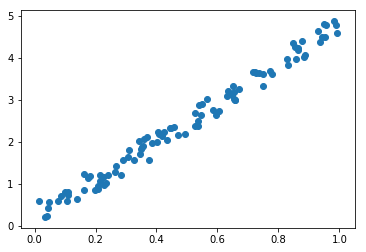

In [6]:
# Visualize our data
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.random.rand(100)
y = np.cos(x) * np.power(x,3) + 4*x + np.random.rand(100)*0.6

plt.scatter(x, y)
plt.show()


Since we're using pytorch, we need to convert our numpy array to a pytorch tensor. The size of the input will be [100, 1], where 100 is the batch size, and 1 is the size of the input (as previously defined in our neural network).

In [7]:
# convert numpy array to tensor in shape of input size
x = torch.from_numpy(x.reshape(-1,1)).float()
y = torch.from_numpy(y.reshape(-1,1)).float()
print(x.size(), y.size())


torch.Size([100, 1]) torch.Size([100, 1])


### Exercise 1: Define the optimizer and loss function

We next define our optimizer and loss function. Since we are performing regression, the loss function we chose is Mean Squared Error, or l2 loss. Another common loss function for regression is the Mean Absolute Error, or l1 loss.


In [8]:
# Define Optimizer and Loss Function
#------------------------------------------------------task 1----------------------------------------------------------------
# Task 1: change optimizer here
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
# Task 1: change loss function here
loss_func = torch.nn.MSELoss()
#----------------------------------------------------------------------------------------------------------------------------


### Training

During training we iterate through our data. Here we use number of epochs = 200, but the optimal number largely depends on the dataset and the task.

The steps are:

1. Clear gradients!!
2. Initialise network
2. Compute loss
3. Compute Backward pass 
4. update network parameters

See how these 4 steps are called for a basic network here:

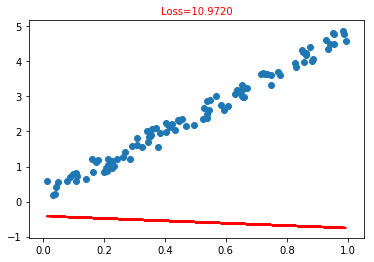

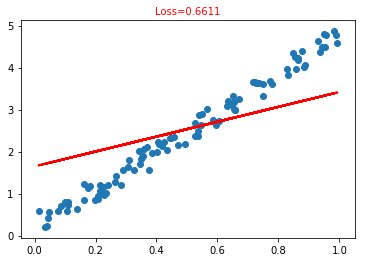

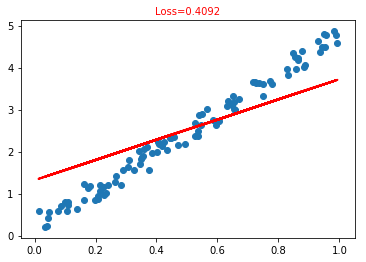

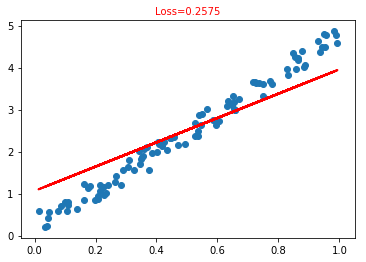

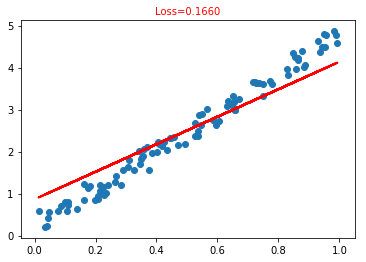

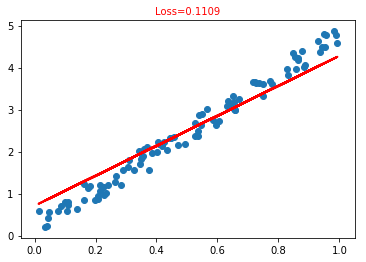

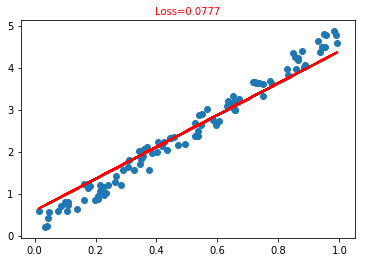

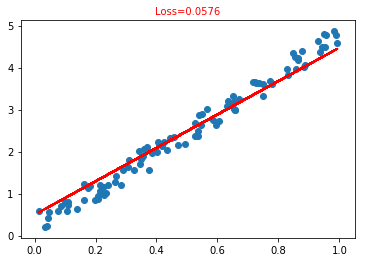

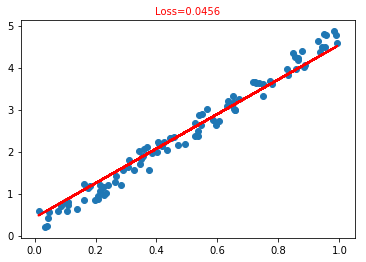

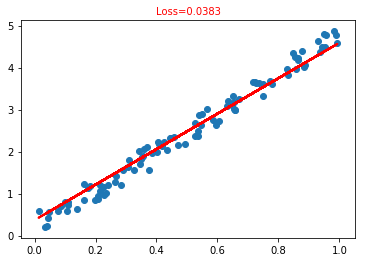

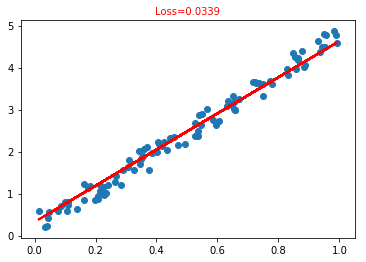

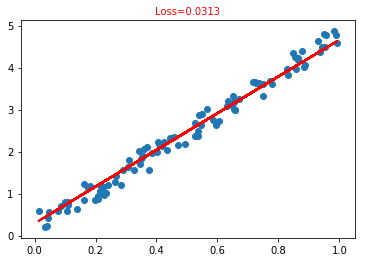

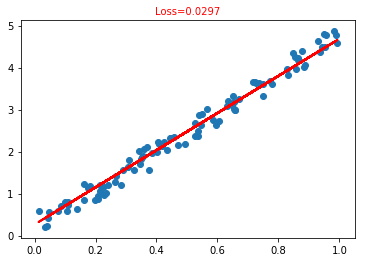

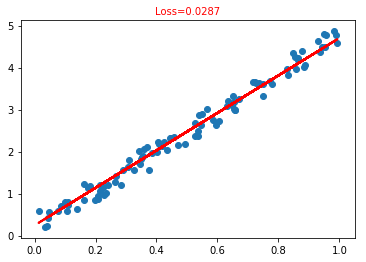

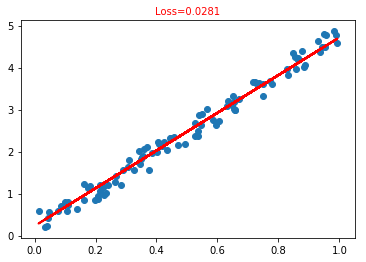

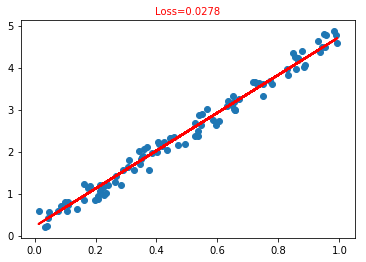

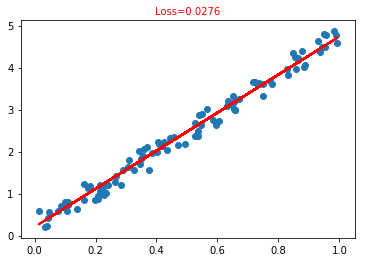

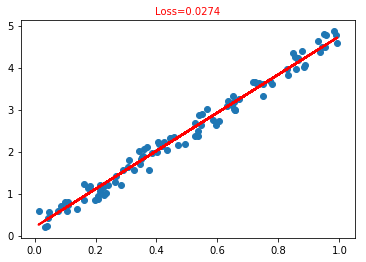

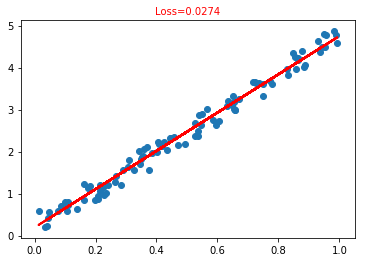

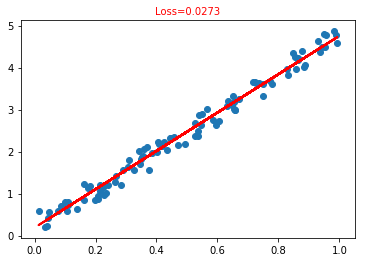

In [9]:
inputs = x 
outputs = y 
epochs = 200
for i in range(epochs):
    
    # 1. clear gradients - here we could interchangibly use net.zero_grad()
    optimizer.zero_grad() 
    
    # 2. pass data through network - note how you never explicitely call the forward pass
    prediction = net(inputs) 
    # 3. Compute loss by calling the loss function defined above
    loss = loss_func(prediction, outputs) 
    # 4. accumulate gradients by calling the backwards pass 
    loss.backward()       
    # 6. update network parameters
    optimizer.step() 

    # Display results
    if i % 10 == 0:
        # note how we need to tranform data back to numpy
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=2)
        plt.title('Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color':  'red'})
        plt.pause(0.1)



Carefully read through this code and check that you understand what all the steps are doing. You are going to need to replicate this basic structure going forward.

### Result

We have now set up and performed simple regression with a neural network. You can see the results above, how in every iteration the red line (the prediction) updates, and moves closer to fit the data.

**You can perform regression with any neural network- the important step to remember is that your final layer should be of output size [1], and the loss function you use is suitable for regression - e.g. mean squared error, absolute squared error**

### Task 1

1. change the loss function to Mean Absolute Error (l1 loss) - which loss function work better?
2. change the optimiser?

## Image Classification with PyTorch - Handwritten Digit Class Prediction

A very common dataset to learn the basics of deep learning, and even to validate new methods is with the MNIST dataset.
The dataset is a set of 60,000 images of handwritten numbers between 0 - 9, of size [28,28] pixels, with labels.

Here is an example of images from the dataset:

![mnist](mnist.png)



Loading the data again form Torchvision.

In [10]:
import torchvision
import numpy as np
from torchvision import datasets, models, transforms

mnist_train_dataset = datasets.MNIST(root = 'mnist_data/train', download= True, train = True, transform = transforms.ToTensor())
mnist_test_dataset = datasets.MNIST(root = 'mnist_data/test', download= True, train = False, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
       mnist_train_dataset, batch_size= 128, shuffle = True)

test_loader = torch.utils.data.DataLoader(
       mnist_test_dataset, batch_size = 128, shuffle = True)

classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')

The transform function converts the images into tensor and normalizes the value. The function torchvision.transforms.MNIST, will download the dataset (if it's not available) in the directory, set the dataset for training if necessary and do the transformation process.



## Exercise 2: MNIST classification using a fully connected (MLP) network

Create an MLP network class consisting of 2 fully connected (linear) hidden layers. We will use ReLu activations for hidden layers and a softmax for the output layer (o ensure the result is a set of probabilities for each class). Each hidden layer will have 50 neurons. 

**To DO 2.1  first sketch the design of your network**

Remember the definition of fully connected networks is that there is a connection between every single neuron. If we consider our input data as the input layer then each feature in the input must connect to each neuron in the first hidden layer. To make this work for images we must first stretch each $28 \times 28$ MNIST image into a single vector (see line 18). This gives us $28 \times 28$ input features. 
 - If our hidden layer each have 50 neurons, what shouod be the sizes of their weights matrices?
 - MNIST has 10 classes, thus how many neurons do we need in our output layer and what will be the dimensions of its weight matrix?

**TO Do 2.2 - complete the `__init__` constructor of a MNIST_MLP class**

1. Use `super` to access functions from the super class
2. Use `nn.linear` ( see https://pytorch.org/docs/stable/nn.html#torch.nn.Linear) to define the first hidden layer. Remeber `in_features` will be the number on input neurons (features) and `out_features` is the number of neurons in the hidden layer. `bias` must be true so that we can shift decision boundaries away from the origin
3. Use `nn.linear` to define the second hidden layer. Given your network design how many input and output neurons should it have?
4. Use `nn.linear` to define the output layer. Given your network design how many input and output neurons should it have?

We define the forward function for you. This determines how the layers (defined in `__init__` are pieced together. You can see how line by line the output of each layer is fed in as the input to the next. 

In [11]:
class MNIST_MLP(nn.Module):
    
    def __init__(self):
        super(MNIST_MLP, self).__init__()
        
        self.fc1 =  nn.Linear(28*28, 50) 
        
        self.fc2 = nn.Linear(50, 50) 
        
        self.fc3 = nn.Linear(50, 10)
        
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x): 
        
        # flattens the MNIST images to a 28 x 28 feature vector 
        #where 28 is the height and width dimensions of each image)
        x = x.view(-1, 28*28) 

        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)  
        
        x = self.softmax(x)
        return x

# After we have defined our model we load it onto our device
model = MNIST_MLP().to(device) 

#### To do 2.3 : Define Optimisers and Loss functions

We suggest the SGD optimizer with momentum and learning rate 0.01 (defined above). What is an appropriate loss function for classification (**hint** we covered this in the last lecture)

In [12]:
optimizer =  torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9) 
loss_function = nn.CrossEntropyLoss()

### Train and Validate

Now we define a train and a test function, which should look rather similar.

They do the following, in order:

- grab a batch of data
- zero all gradients (train only)
- pass the data through the network
- evaluate the loss and record it (if necessary)
- backpropagate the loss and update the parameters (train only)

**To do 2.4 check you know what each line in these functions is doing?**

Comment each line of code to check you know what each function is doing. What is different about the two functions?

In [13]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    # enumerate is an iterator similar to iter() 
    #except that it also gives the batch number 
    for batch_number, (images, labels) in enumerate(train_loader):
        
        # Copy data to GPU if needed
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero all the gradients before each batch
        optimizer.zero_grad() 
        
        # Pass the data through the network
        output = model(images)

        # Calculate loss
        loss = loss_function(output, labels)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_number % log_interval == 0: 
            # print the loss every 'log_interval' batch
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_number * len(images), len(train_loader.dataset),
                100. * batch_number / len(train_loader), loss.data.item()))

In [14]:
def validate(loss_vector, accuracy_vector):
    # Set the model to evaluate mode. 
    
    model.eval()
    
    val_loss, correct = 0, 0
    for images, labels in test_loader:
        # again the data is copied to the GPU if needed
        images = images.to(device)
        labels = labels.to(device)
        
        # pass the images to the model
        
        output = model(images)
        
        # here we are intersted in the total loss
        val_loss += loss_function(output, labels).data.item()  
        
        # get the index of the max log-probability
        pred = output.data.max(1)[1] 
        # we sum the cases where the prediction and the label match
        # we need this data to be in the cpu to calculate   
        correct += pred.eq(labels.data).cpu().sum()
                                                   
    # now we divide the sum val loss by the total number of validation images
    # to give an average validation loss
    val_loss /= len(test_loader) 
                                      
    # we store this for possible graphing later
    loss_vector.append(val_loss) 

    
    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)  
    
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(test_loader.dataset), accuracy))

### Train/eval mode

Note that it is essential that the model be set to train/eval mode depending on whether its training or validating (being applied to validation/test data). If in eval mode, the gradients will not be calculated, backpropagation will not take place and things like dropout will be set to evaluate mode so the network does not vary in response to the data for different runs.

**To do 2.5 Run the training loop**

We have set the network to run for 7 epochs but feel free to experiment with this. What happens if you change the number of neurons in the network class?

In [15]:
epochs = 7

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304102
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.297816
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.273540

Validation set: Average loss: 2.2562, Accuracy: 1254/10000 (13%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.228694
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.012141
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.759890

Validation set: Average loss: 1.7399, Accuracy: 7787/10000 (78%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.742805
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.686480
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.691702

Validation set: Average loss: 1.6440, Accuracy: 8335/10000 (83%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.710755
Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.631487
Train Epoch: 4 [51200/60000 (85%)]	Loss: 1.597921

Validation set: Average loss: 1.6269, Accuracy: 8418/10000 (84%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.640469
Train Epoch: 5 [25600/60000 (43%)]	Loss: 1.665523
Train Epoch: 5 [51200/60000 (85%)]	Loss: 1.669536

Valida

Finally, we can plot our validation loss and accuracy in a graph to see our progress:

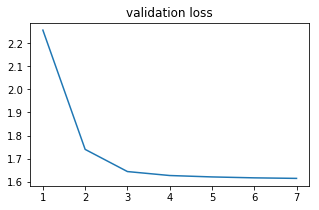

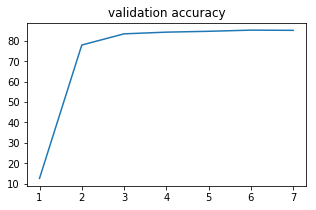

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

Done! We've trained an MLP! Is this a good network? For reference, a test accuracy of below ~97% on MNIST is considered poor.

**(Optional) task** reimplement using `nn.sequential` and check you get the same result

## Exercise 3: MNIST classification using a simple convolutional network

We next extend to a convolutional implementation and investigate whether this boosts training.

First let us redefine our DataLoaders with smaller batch sizes.

In [17]:
train_loader = torch.utils.data.DataLoader(
       mnist_train_dataset, batch_size= 8, shuffle = True)

test_loader = torch.utils.data.DataLoader(
       mnist_test_dataset, batch_size = 8, shuffle = True)

We create a network with 2 convolutional layers with max pooling and relu non-linearities. This is followed by two fully connected layers. The first layer is connected to all activations from the final convolutional layer and has 50 neurons. The second connects the 50 neurons of the penultimate layer to 10 output neurons (for the number of classes). Again , the final layer is followed by a softmax layer to return probabilities of the raining example belonging to each class. 

**To Do 3.1 edit the number of input and output channels of the convolutional layers**

1. MNIST is grayscale; thus how many input channels do you think this will be?
2. The first convolutional layer has a kernel size of $5 \times 5 $ and learns 10 output channels (in other words the neurons learn 10 $5 \times 5$ image filters. 
3. The second layer has a kernel size of $5 \times 5 $ and learns 20 output channels. 

The dimensions of linear layer  are trickier to work out. Each neuron in the output must connect to each activation in the second convolutional layer. We see that the network applies $5\times 5$ kernels with no padding and has downsamples through pooling twice. This results in the following reductions in spatial dimensions
- conv1 downsamples from $28 \times 28$ to $24 \times 24$
- maxpool1 downsamples from $24 \times 24$ to $12 \times 12$
- conv2 downsamples from $12 \times 12$ to $8 \times 8$
- maxpool1 downsamples from $8 \times 8$ to $4 \times 4$
- Thus the activations of the final convolution layer have spatial dimensions $4 \times 4$; how many output activations os this

**To Do 3.2 The first fully connected layer has 50 neurons and the second has 10 neurons; input the number of input and output features for these layers**

Try completing and running the code below and outputting the shape of the outputs (`x`) for each step in the forward pass, to debug and check the above calculations are correct.


In [18]:
import torch.nn as nn


class MNIST_Model(nn.Module):
    def __init__(self):
        super(MNIST_Model, self).__init__()
    
        self.conv1=nn.Conv2d(1, 10, kernel_size=5)
        self.maxpool1=nn.MaxPool2d(2)
        self.dropout1=nn.Dropout2d()
        
        self.conv2=nn.Conv2d(10, 20, kernel_size=5)
        self.maxpool2=nn.MaxPool2d(2)
        self.dropout2=nn.Dropout2d()
        
        self.lin_blocks = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            #nn.Softmax(),
        )
        
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = x.view(x.size(0),-1)
        x = self.lin_blocks(x)

        return F.log_softmax(x,dim=1)

    
net = MNIST_Model() 
print(net)
net = net.to(device)

MNIST_Model(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (lin_blocks): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


### Loss function and optimizer

We again need to define our loss and optimizers. In this case, since we're doing classification, we use **CrossEntropy Loss**, a commonly used loss function for classification.


In [19]:
import torch.optim as optim

loss_fun = nn.CrossEntropyLoss()
loss_fun = loss_fun.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Training 

We will now train our classifer model - this time iterating using enumerate. 

### To do 3.3. Implement the training interations

Implement the following steps:

1. load data and labels to device
2. clear the gradient
3. feed the input and acquire the output from network
4. calculating the predicted and the expected loss
5. compute the gradient
6. update the parameters

**Hint** use examples from regression and MLP tasks

**Don't forget! to clear gradients at the beginning of each epoch else they will be acculuated across eacg mini batch**

In [20]:
epochs = 1
for epoch in range(epochs): 

    # enumerate can be used to output iteration index i, as well as the data 
    for i, (data, labels) in enumerate(train_loader, 0):
        
        # Task 3.1 load data and labels to device
        data = data.to(device)
        labels = labels.to(device)
        
        # --------------------------------------------------task 2 ------------------------------------------------------------
        # 3.2: implement training iteration here
        # clear the gradient
        optimizer.zero_grad()

        #3.3 feed the input and acquire the output from network
        outputs = net(data)

        #3.4 calculating the predicted and the expected loss
        loss = loss_fun(outputs, labels)

        #3.5 compute the gradient
        loss.backward()

        #3.6 update the parameters
        optimizer.step()
        # ---------------------------------------------------------------------------------------------------------------------

        # print statistics
        ce_loss = loss.item()
        if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))


[1,     1] loss: 2.333
[1,    11] loss: 2.251
[1,    21] loss: 2.375
[1,    31] loss: 2.304
[1,    41] loss: 2.377
[1,    51] loss: 2.298
[1,    61] loss: 2.293
[1,    71] loss: 2.362
[1,    81] loss: 2.243
[1,    91] loss: 2.291
[1,   101] loss: 2.335
[1,   111] loss: 2.311
[1,   121] loss: 2.318
[1,   131] loss: 2.278
[1,   141] loss: 2.334
[1,   151] loss: 2.275
[1,   161] loss: 2.362
[1,   171] loss: 2.278
[1,   181] loss: 2.275
[1,   191] loss: 2.305
[1,   201] loss: 2.326
[1,   211] loss: 2.345
[1,   221] loss: 2.300
[1,   231] loss: 2.347
[1,   241] loss: 2.266
[1,   251] loss: 2.249
[1,   261] loss: 2.300
[1,   271] loss: 2.228
[1,   281] loss: 2.245
[1,   291] loss: 2.300
[1,   301] loss: 2.213
[1,   311] loss: 2.188
[1,   321] loss: 2.236
[1,   331] loss: 2.312
[1,   341] loss: 2.272
[1,   351] loss: 2.226
[1,   361] loss: 2.273
[1,   371] loss: 2.301
[1,   381] loss: 2.189
[1,   391] loss: 2.102
[1,   401] loss: 2.264
[1,   411] loss: 2.068
[1,   421] loss: 2.170
[1,   431] 

[1,  3591] loss: 0.044
[1,  3601] loss: 0.124
[1,  3611] loss: 0.922
[1,  3621] loss: 1.350
[1,  3631] loss: 0.095
[1,  3641] loss: 0.731
[1,  3651] loss: 0.846
[1,  3661] loss: 0.405
[1,  3671] loss: 0.282
[1,  3681] loss: 0.090
[1,  3691] loss: 2.597
[1,  3701] loss: 0.112
[1,  3711] loss: 0.097
[1,  3721] loss: 0.101
[1,  3731] loss: 0.429
[1,  3741] loss: 0.430
[1,  3751] loss: 0.006
[1,  3761] loss: 0.523
[1,  3771] loss: 0.126
[1,  3781] loss: 0.919
[1,  3791] loss: 0.248
[1,  3801] loss: 0.494
[1,  3811] loss: 0.096
[1,  3821] loss: 0.211
[1,  3831] loss: 0.554
[1,  3841] loss: 0.229
[1,  3851] loss: 0.689
[1,  3861] loss: 0.247
[1,  3871] loss: 0.279
[1,  3881] loss: 0.425
[1,  3891] loss: 0.147
[1,  3901] loss: 0.530
[1,  3911] loss: 0.243
[1,  3921] loss: 0.261
[1,  3931] loss: 0.065
[1,  3941] loss: 0.279
[1,  3951] loss: 0.817
[1,  3961] loss: 0.160
[1,  3971] loss: 0.164
[1,  3981] loss: 0.047
[1,  3991] loss: 0.099
[1,  4001] loss: 0.296
[1,  4011] loss: 0.283
[1,  4021] 

[1,  7171] loss: 0.248
[1,  7181] loss: 0.235
[1,  7191] loss: 1.044
[1,  7201] loss: 0.425
[1,  7211] loss: 0.292
[1,  7221] loss: 0.101
[1,  7231] loss: 0.018
[1,  7241] loss: 0.235
[1,  7251] loss: 0.602
[1,  7261] loss: 0.046
[1,  7271] loss: 0.028
[1,  7281] loss: 0.300
[1,  7291] loss: 0.076
[1,  7301] loss: 0.066
[1,  7311] loss: 0.140
[1,  7321] loss: 0.228
[1,  7331] loss: 0.087
[1,  7341] loss: 0.248
[1,  7351] loss: 0.249
[1,  7361] loss: 0.054
[1,  7371] loss: 0.180
[1,  7381] loss: 0.020
[1,  7391] loss: 0.041
[1,  7401] loss: 0.103
[1,  7411] loss: 0.056
[1,  7421] loss: 0.134
[1,  7431] loss: 0.299
[1,  7441] loss: 0.091
[1,  7451] loss: 0.635
[1,  7461] loss: 0.031
[1,  7471] loss: 1.324
[1,  7481] loss: 0.067
[1,  7491] loss: 0.078


### Testing

We will now use our trained network to make a prediction on our test set. 


In [21]:
#make an iterator from test_loader
test_iterator = iter(test_loader)
#Get a batch of testing images
images, labels = test_iterator.next()
images = images.to(device)
labels = labels.to(device)

Predicted:      3     3     2     4     7     6     3     6


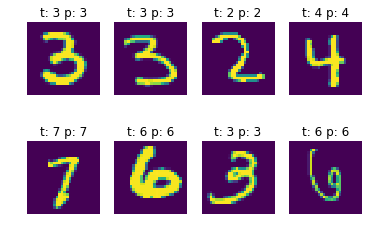

In [22]:
y_score = net(images)
# get predicted class from the class probabilities
_, y_pred = torch.max(y_score, 1)

print('Predicted: ', ' '.join('%5s' % classes[y_pred[j]] for j in range(8)))
rows = 2
columns = 4
# plot y_score - true label (t) vs predicted label (p)
fig2 = plt.figure()
for i in range(8):
    fig2.add_subplot(rows, columns, i+1)
    plt.title('t: ' + classes[labels[i].cpu()] + ' p: ' + classes[y_pred[i].cpu()])
    img = images[i] / 2 + 0.5     # this is to unnormalize the image
    img = torchvision.transforms.ToPILImage()(img.cpu())
    plt.axis('off')
    plt.imshow(img)
plt.show()


### Computing classification scores

We will now use the predictions to compute the accuracy, f1 score, precision and recall. These are scores commonly used to evaluate classification, in particular the f1 score is a good measure for datasets with imbalanced classes.

In [23]:
# first convert tensors to numpy
y_true = labels.data.cpu().numpy()
y_pred = y_pred.data.cpu().numpy()

You can use sklearn classification metrics to calculate the scores - you will need to input the true labels, and predicted classes.

See https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics for more details.

In [24]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print('accuracy:', accuracy, ', f1 score:', f1, ', precision:', precision, ', recall:', recall)

accuracy: 1.0 , f1 score: 1.0 , precision: 1.0 , recall: 1.0


## Optional Extras 

1. Try reducing the lines of code in the convolutional neural network class by grouping lines of code into `nn.Sequential` blocks

## References

This tutorial was inspired by https://www.guru99.com/pytorch-tutorial.html

Written by Cher Bass (cher.bass[at].kcl.ac.uk) and Abdulah Fawaz (abdulah.fawaz[at]kcl.ac.uk)
